Name: Antony Krymski

Username: agk-123

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Flatten, Dense, LSTM, Reshape, MaxPooling2D, LayerNormalization, TimeDistributed, GRU, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

plt.style.use("bmh")
plt.rcParams.update({'font.size': 10})

def scale(a):
    # minmax scaling 
    maxv = np.max(a, axis=0)
    minv = np.min(a, axis=0)
    return (a - minv) / (maxv - minv) * 2. - 1.

def split(X, y, test_size=0.33):
    # timeseries split 
    i = int(np.floor(len(X) * (1 - test_size)))
    X_train, y_train = X[:i], y[:i]
    X_test, y_test = X[i:], y[i:]
    return X_train, X_test, y_train, y_test

def window(data, timesteps, strides=1):
    # windowing data 
    x = []
    for i in range(0, len(data) - timesteps, strides):
        x.append(data[i:i+timesteps])
    return np.array(x)

def download(ticker='^GSPC'):
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=0&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true'
    return pd.read_csv(url, index_col='Date', parse_dates=True)

def plot(x):
    plt.figure(figsize=(16, 2))
    plt.margins(x=0, y=0)
    plt.plot(x)
    plt.show()

def plot_forecast(x, y, y_pred):
    t1 = np.arange(0, len(x), 1)
    t2 = np.arange(len(x), len(x) + len(y), 1)
    fig, ax = plt.subplots(figsize=(16, 2))
    ax.margins(x=0, y=0)
    ax.plot(t1, x, color='blue')
    ax.plot(t2, y, color='blue', label='Actual')
    ax.plot(t2, y_pred, color='red', label='Forecast')
    ax.axvline(x=len(x), color='gray', linestyle='--')
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_timeseries(**kwargs):
    fig, (ax) = plt.subplots(1, 1, sharex=True, figsize=(16, 2))
    ax.margins(x=0, y=0)
    index = kwargs['index'] if 'index' in kwargs else None
    for key, value in kwargs.items():
        if key == 'title':
            ax.set_title(value)
        elif key == 'index':
            pass
        else:
            if index is None:
                ax.plot(value, label=key)
            else:
                ax.plot(index, value, label=key)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

def plot_training(history, metric='loss'):
    plot_timeseries(index=range(history.params['epochs']), title=metric, train=history.history[metric], test=history.history['val_' + metric])

In [3]:
TIMESTEPS = 250
FEATURES = 1
CODE_SIZE = 32
BATCH_SIZE = 256

# Data

# Pre-processing

In [4]:
# Download our time series 
timeseries = download('^SPX')['Close']
# Transform to log returns
timeseries = np.log(timeseries).diff().dropna()
timeseries

Date
1970-01-05    0.004934
1970-01-06   -0.006871
1970-01-07   -0.002049
1970-01-08    0.000540
1970-01-09   -0.003026
                ...   
2024-08-20   -0.001987
2024-08-21    0.004231
2024-08-22   -0.008973
2024-08-23    0.011418
2024-08-26   -0.004131
Name: Close, Length: 13782, dtype: float64

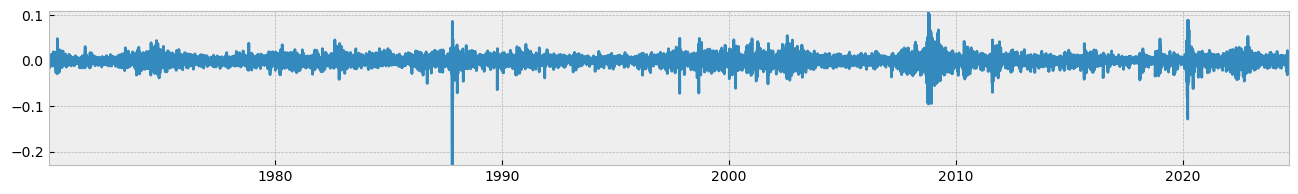

In [5]:
plot(timeseries)

Outliers 0.035878181362578504


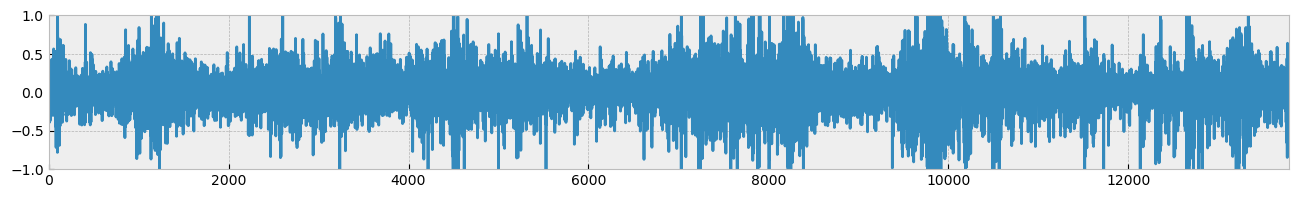

In [6]:
X = timeseries.values

# remove outliers
outliers = np.quantile(np.abs(X), 0.99)
X = np.clip(X, -outliers, outliers)
print('Outliers', outliers)

# scale
X = X / outliers

plot(X)

In [7]:
# generate lags
X = window(X, TIMESTEPS).astype(np.float32)
y = timeseries[TIMESTEPS:]

x_train, x_test, y_train, y_test = split(X, y, 0.3)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

assert(np.isfinite(X).all() == True)
assert(np.isfinite(y).all() == True)

(9472, 250) (4060, 250)
(9472,) (4060,)


In [8]:
evals = pd.DataFrame(index=['RMSE', 'MAE'])

def eval(name, y_pred, y_test):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    evals[name] = [ rmse, mae ]

In [9]:
# Base cases
eval('Persistence', y_test.shift(1).fillna(0), y_test)
eval('Zero', np.zeros(len(y_test)), y_test)
eval('Mean', np.full(len(y_test), np.mean(x_train[:, -1])), y_test)
evals

,Persistence,Zero,Mean
RMSE,0.019129,0.012773,0.015133
MAE,0.012069,0.008113,0.010991


In [10]:
# Linear Regression
model = LinearRegression()
model.fit(x_train, y_train)
eval('LR', model.predict(x_test), y_test)

In [11]:
# # ARIMA
# import pmdarima as pm
# model = pm.auto_arima(x_train[:, -1], stationary=True, maxiter=5)
# eval('ARIMA', model.predict(len(x_test)), y_test)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/5


2024-08-26 17:02:46.088301: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


37/37 [==============================] - 5s 96ms/step - loss: 1.7049e-04 - mae: 0.0092 - val_loss: 1.7465e-04 - val_mae: 0.0086
Epoch 2/5
37/37 [==============================] - 3s 83ms/step - loss: 1.1860e-04 - mae: 0.0079 - val_loss: 1.6442e-04 - val_mae: 0.0081
Epoch 3/5
37/37 [==============================] - 3s 82ms/step - loss: 1.1175e-04 - mae: 0.0076 - val_loss: 1.7728e-04 - val_mae: 0.0087
Epoch 4/5
37/37 [==============================] - 3s 82ms/step - loss: 1.0857e-04 - mae: 0.0075 - val_loss: 1.7356e-04 - val_mae: 0.0085
Epoch 5/5
37/37 [==============================] - 3s 82ms/step - loss: 1.0634e-04 - mae: 0.0074 - val_loss: 1.7019e-04 - val_mae: 0.0087


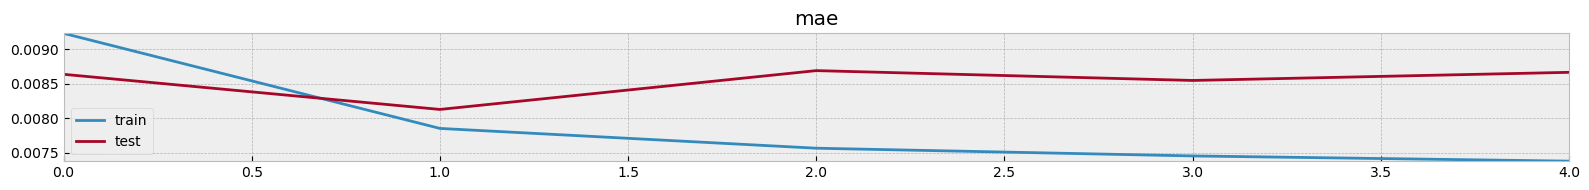

127/127 [==============================] - 2s 12ms/step


In [12]:
def build_lstm(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(input)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="linear")(x)
    return Model(input, x)

model = build_lstm((TIMESTEPS, FEATURES))
model.compile(loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=5, validation_data=(x_test, y_test))
plot_training(history, 'mae')

eval('LSTM', model.predict(x_test), y_test)

In [13]:
evals

,Persistence,Zero,Mean,LR,LSTM
RMSE,0.019129,0.012773,0.015133,0.013049,0.013046
MAE,0.012069,0.008113,0.010991,0.008356,0.008664


# Data Generation

In [14]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, timesteps=TIMESTEPS):
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = data
        self.indexes = np.arange(len(self.data) - (timesteps * 1) - timesteps)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indexes) // self.batch_size
    
    def get_window(self, idx):
        return self.data[idx:idx+self.timesteps, 0]
    
    def __getitem__(self, batch):
        'Generate one batch of data'
        x = []
        y = []
        labels = []
        
        indexes = self.indexes[batch*self.batch_size//2:(batch+1)*self.batch_size//2]

        for idx in indexes:
            x_positive = self.get_window(idx)
            y_positive = self.get_window(idx + self.timesteps)
            y_negative = np.random.normal(np.mean(x_positive), np.std(x_positive), len(x_positive))

            # positive sample
            x.append(x_positive)
            y.append(y_positive)
            labels.append(1)

            # negative sample
            x.append(x_positive)
            y.append(y_negative)
            labels.append(0)
        
        x = np.array(x).astype(np.float32)
        y = np.array(y).astype(np.float32)
        labels = np.array(labels).astype(np.float32)

        x = np.expand_dims(x, axis=-1)
        y = np.expand_dims(y, axis=-1)
        
        return (x, y), labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

Batches: 35
x shape: (256, 250, 1), y shape: (256, 250, 1), labels shape: (256,)


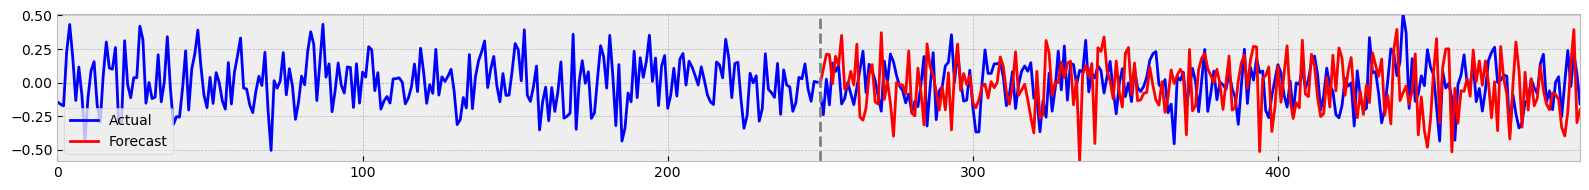

In [15]:
# Test generator
dg = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True)
print('Batches:', len(dg))

# Get the first batch
(bx, by), labels = dg.__getitem__(0)
print(f"x shape: {bx.shape}, y shape: {by.shape}, labels shape: {labels.shape}")

plot_forecast(bx[0, :, 0], by[0, :, 0], by[1, :, 0])

# CPC Model Architecture

In [16]:
def build_encoder(input_shape, code_size):
    input = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same')(input)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    # x = Flatten()(x)
    # x = Dropout(0.5)(x)
    x = Dense(code_size, activation='linear', name='encoder_embedding')(x)
    return Model(input, x, name='encoder')

encoder = build_encoder((TIMESTEPS, FEATURES), CODE_SIZE)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 250, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 64)           12352     
                                                                 
 encoder_embedding (Dense)   (None, 250, 32)           2080      
                                                                 
Total params: 14,688
Trainable params: 14,688
Non-trainable params: 0
_________________________________________________________________


In [20]:
def build_context(input_shape, code_size):
    '''Build the autoregressive model doing predictions'''
    input = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True, name="context")(input)
    x = LSTM(128, return_sequences=True)(x)
    # x = LSTM(64, return_sequences=False, name="context")(input)
    x = Dense(code_size, activation="linear", name="preds")(x)
    return Model(input, x, name="context")

context = build_context((TIMESTEPS, CODE_SIZE), CODE_SIZE)
context.summary()

Model: "context"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 250, 32)]         0         
                                                                 
 context (LSTM)              (None, 250, 128)          82432     
                                                                 
 lstm_2 (LSTM)               (None, 250, 128)          131584    
                                                                 
 preds (Dense)               (None, 250, 32)           4128      
                                                                 
Total params: 218,144
Trainable params: 218,144
Non-trainable params: 0
_________________________________________________________________


In [21]:
x_input = Input((TIMESTEPS, FEATURES))
x_encoded = encoder(x_input)

y_pred = context(x_encoded)
# y_pred = x_encoded[-1]

y_input = Input((TIMESTEPS, FEATURES))
y_encoded = encoder(y_input)

output = K.mean(y_encoded * y_pred, axis=-1)
output = K.mean(output, axis=-1, keepdims=True)  # along the temporal dimension
output = K.sigmoid(output)

model = Model(inputs=[x_input, y_input], outputs=output, name='CPC')
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])
model.summary()

Model: "CPC"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 250, 1)]     0           []                               
                                                                                                  
 encoder (Functional)           (None, 250, 32)      14688       ['input_8[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 context (Functional)           (None, 250, 32)      218144      ['encoder[2][0]']              

In [22]:
train_gen = DataGenerator(x_train, batch_size=BATCH_SIZE, shuffle=True)
test_gen = DataGenerator(x_test, batch_size=BATCH_SIZE, shuffle=True)

In [25]:
history = model.fit(train_gen, epochs=5, validation_data=test_gen)

Epoch 1/5
35/35 [==============================] - 10s 277ms/step - loss: 0.3241 - binary_accuracy: 0.8768 - val_loss: 0.4715 - val_binary_accuracy: 0.8176
Epoch 2/5
35/35 [==============================] - 9s 269ms/step - loss: 0.3264 - binary_accuracy: 0.8657 - val_loss: 0.5270 - val_binary_accuracy: 0.8185
Epoch 3/5
35/35 [==============================] - 10s 274ms/step - loss: 0.2898 - binary_accuracy: 0.8886 - val_loss: 0.4846 - val_binary_accuracy: 0.7785
Epoch 4/5
35/35 [==============================] - 9s 271ms/step - loss: 0.2803 - binary_accuracy: 0.8865 - val_loss: 0.4549 - val_binary_accuracy: 0.8107
Epoch 5/5
35/35 [==============================] - 9s 268ms/step - loss: 0.2539 - binary_accuracy: 0.9020 - val_loss: 0.5094 - val_binary_accuracy: 0.8194


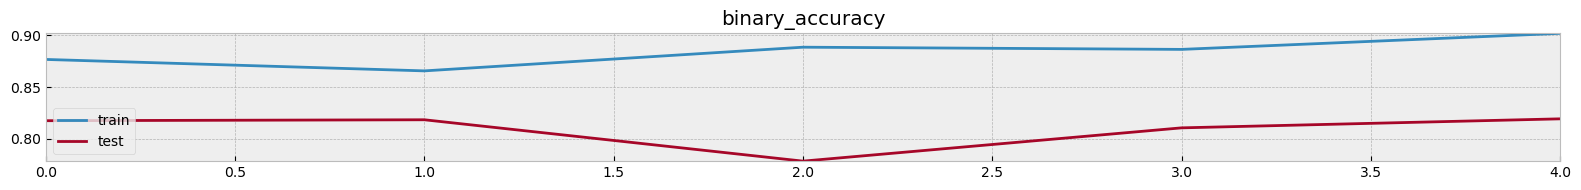

In [26]:
plot_training(history, 'binary_accuracy')

In [27]:
encoder.save('encoder.h5')

# Downstream Task

In [34]:
encoder = load_model('encoder.h5', compile=True)

In [35]:
# Compute embeddings for each window
x_train_embeds = encoder.predict(x_train)[:, -1, :]
x_test_embeds = encoder.predict(x_test)[:, -1, :]

127/127 [==============================] - 0s 3ms/step


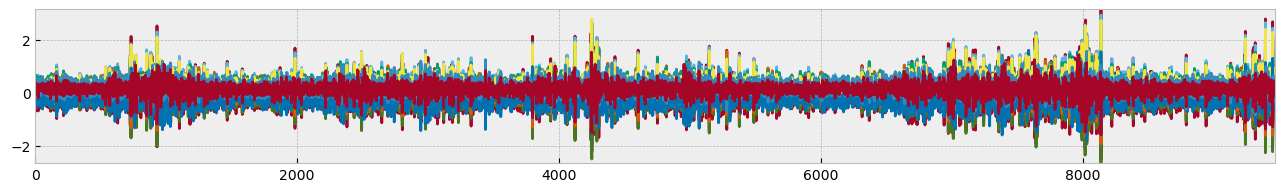

In [30]:
plot(x_train_embeds)

In [37]:
# Normalize each embedding vector to unit norm
x_train_embeds = x_train_embeds / np.linalg.norm(x_train_embeds, axis=1, keepdims=True)
x_test_embeds = x_test_embeds / np.linalg.norm(x_test_embeds, axis=1, keepdims=True)

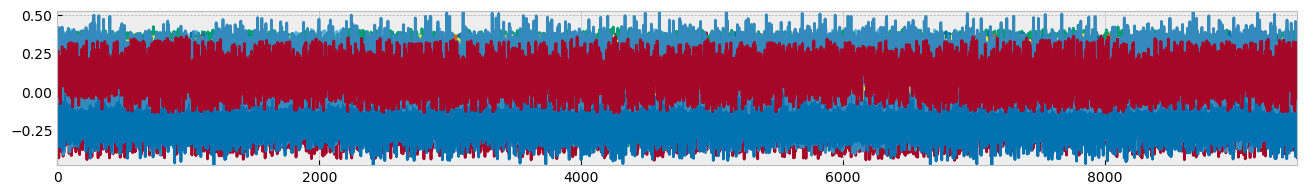

In [38]:
plot(x_train_embeds)

/Users/antonykrymski/miniconda3/envs/tf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


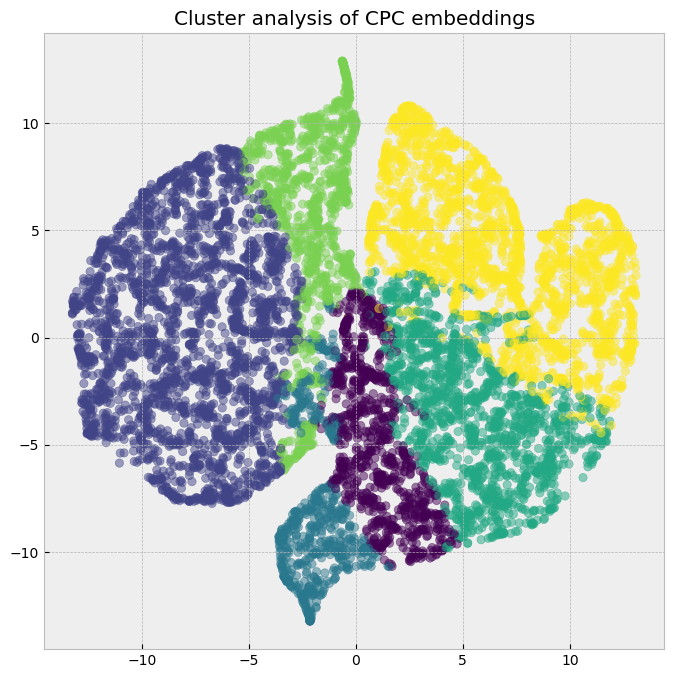

In [44]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_tsne = tsne.fit_transform(x_train_embeds)

# Apply K-means clustering
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(x_train_embeds)

# Visualize the clusters using the t-SNE embeddings
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('Cluster analysis of CPC embeddings')
plt.show()

In [45]:
# Linear Regression with CPC embeddings
model = LinearRegression()
model.fit(x_train_embeds, y_train)
eval('CPC-LR', model.predict(x_test_embeds), y_test)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,337
Trainable params: 6,337
Non-trainable p

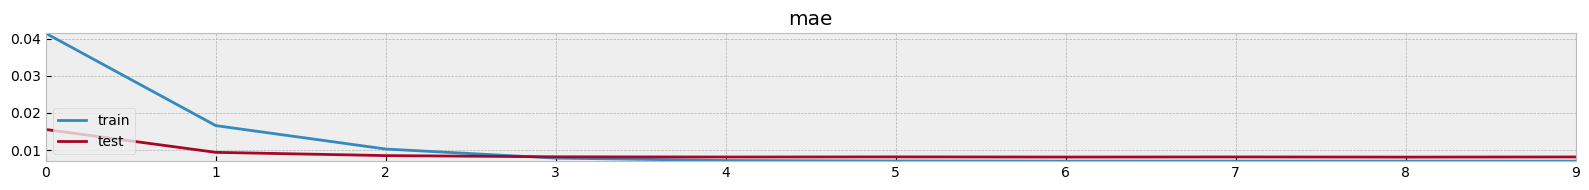

127/127 [==============================] - 0s 2ms/step


In [46]:
def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='linear')(x)
    return Model(input, x)

model = build_dense(CODE_SIZE)
model.compile(loss='mse', metrics=['mae'])
model.summary()

history = model.fit(x_train_embeds, y_train, batch_size=BATCH_SIZE, epochs=10, validation_data=(x_test_embeds, y_test))
plot_training(history, 'mae')

eval('CPC', model.predict(x_test_embeds), y_test)

In [47]:
evals

,Persistence,Zero,Mean,LR,LSTM,CPC-LR,CPC
RMSE,0.019129,0.012773,0.015133,0.013049,0.013046,0.012871,0.012805
MAE,0.012069,0.008113,0.010991,0.008356,0.008664,0.008171,0.008140


# Optimize Sharpe

In [82]:
train_returns = timeseries[TIMESTEPS-1:][:len(x_train)]
test_returns = timeseries[-len(x_test)-1:-1]

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_52 (Dense)            (None, 32)                1056      
                                                                 
 dropout_35 (Dropout)        (None, 32)                0         
                                                                 
 dense_53 (Dense)            (None, 32)                1056      
                                                                 
 dropout_36 (Dropout)        (None, 32)                0         
                                                                 
 dense_54 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,145
Trainable params: 2,145
Non-trainable 

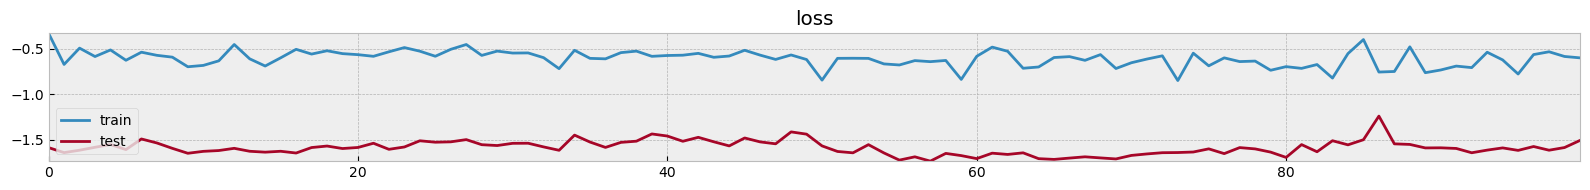

In [112]:
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    # if (std_return <= 0): return 0.
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252.0)

def sharpe_loss(log_returns, allocations):
    portfolio_returns = log_returns[1:, 0] * allocations[:-1, 0]
    # Negative Sharpe ratio (to maximize it)
    return -sharpe_ratio(portfolio_returns)

def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(32, activation='relu')(input)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(input, x)

model = build_dense(CODE_SIZE)
model.compile(loss=sharpe_loss)
model.summary()

history = model.fit(x_train_embeds, train_returns, batch_size=32, epochs=100, validation_data=(x_test_embeds, test_returns))
plot_training(history, 'loss')

In [116]:
allocations = model.predict(x_test_embeds)[:, 0]
portfolio_returns = test_returns[1:] * allocations[:-1]


sharpe_ratio(test_returns[1:]).numpy(), sharpe_ratio(portfolio_returns).numpy()

127/127 [==============================] - 0s 1ms/step


(0.4625010356771534, 0.5430515890552791)

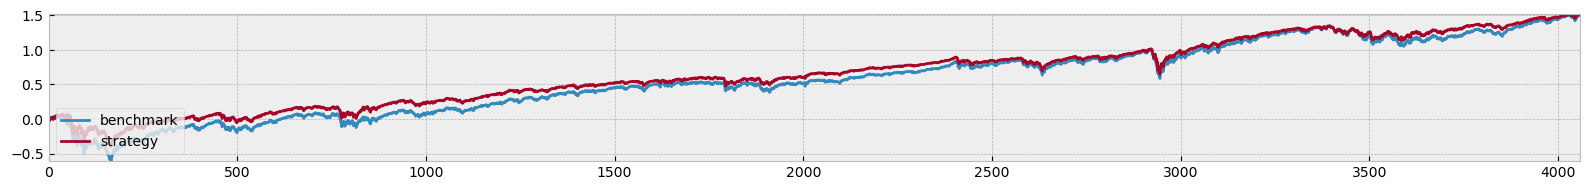

In [117]:
plot_timeseries(index=np.arange(len(x_test)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))

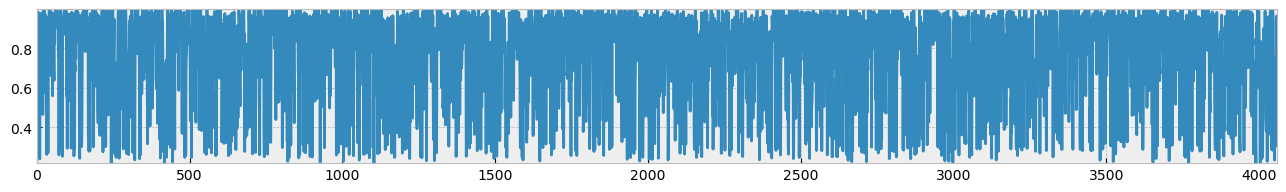

In [118]:
plot(allocations)

In [269]:
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras import models

# Define the model architecture
def create_model(input_shape):
    model = models.Sequential([
        Input(shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='tanh')
        # layers.Lambda(lambda x: -tf.math.abs(x))
    ])
    return model

# Function to calculate Sharpe ratio
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252)  # Annualize Sharpe ratio

# Custom training loop with gradient ascent for a single batch
def train_step(model, log_returns, features, optimizer):
    with tf.GradientTape() as tape:
        allocations = model(features, training=True)  # Forward pass
        # Shift allocations back by one period
        portfolio_returns = log_returns[1:] * allocations[:-1, 0]
        # portfolio_returns = tf.reduce_sum(log_returns[1:] * allocations[:-1], axis=1)
        sharpe = sharpe_ratio(portfolio_returns)
        loss = -sharpe  # Negative Sharpe ratio (to maximize it)
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # print(sharpe.shape, portfolio_returns.shape, allocations.shape)
    return sharpe

def train_rl(features, log_returns, epochs_per_step=1, lr=0.001, window_size=120):
    assert len(log_returns) == len(features)
    allocations = np.zeros_like(log_returns)
    
    model = create_model(features.shape[1])
    optimizer = optimizers.legacy.Adam(learning_rate=lr, clipnorm=1.0)
    
    train_sharpe_history = []
    test_sharpe_history = []

    # Rolling window online learning
    for i in range(window_size, len(log_returns), window_size):
        # Train the model up to the current window
        for epoch in range(epochs_per_step):
            sharpe = train_step(model, log_returns[:i], features[:i], optimizer)
            
        if i >= len(log_returns) - window_size:
            window_size = len(log_returns) - i
        
        # Predict next window
        allocations[i:i+window_size] = model.predict(features[i:i+window_size])[:, 0]

        # Shift allocations back by one period for testing as well
        sharpe_test = sharpe_ratio(log_returns[1:i+window_size] * allocations[:i+window_size-1])

        # Append Sharpe ratios to history
        train_sharpe_history.append(sharpe.numpy())  # Convert TensorFlow tensor to a NumPy array
        test_sharpe_history.append(sharpe_test.numpy())
        
        print(f'Step {i}/{len(log_returns)}, Train Sharpe: {sharpe:.4f}, Test Sharpe {sharpe_test:.4f}')

    return allocations, model, (train_sharpe_history, test_sharpe_history)


In [270]:
# features_scaled = scale_embs(features)
log_returns = timeseries.values

def compute_embeddings(x):
    x = window(x, TIMESTEPS, 1)
    return encoder.predict(np.array(x))[:, -1, :]

def scale_embs(x):
    x = x / np.linalg.norm(x, axis=1, keepdims=True)
    return x

features_s = scale_embs(compute_embeddings(timeseries.values))

print(features_s.shape, log_returns[TIMESTEPS:].shape)

allocations, model, history = train_rl(features_s, log_returns[TIMESTEPS:], epochs_per_step=1, lr=0.0001, window_size=120)

423/423 [==============================] - 2s 4ms/step
(13531, 32) (13531,)
4/4 [==============================] - 0s 41ms/step
Step 120/13531, Train Sharpe: 3.6757, Test Sharpe -0.1479
4/4 [==============================] - 0s 27ms/step
Step 240/13531, Train Sharpe: 1.2199, Test Sharpe 0.9337
4/4 [==============================] - 0s 22ms/step
Step 360/13531, Train Sharpe: 2.0065, Test Sharpe 0.9739
4/4 [==============================] - 0s 25ms/step
Step 480/13531, Train Sharpe: 1.8284, Test Sharpe 0.4060
4/4 [==============================] - 0s 18ms/step
Step 600/13531, Train Sharpe: 1.1034, Test Sharpe 0.3673
4/4 [==============================] - 0s 16ms/step
Step 720/13531, Train Sharpe: 0.7644, Test Sharpe -0.0357
4/4 [==============================] - 0s 16ms/step
Step 840/13531, Train Sharpe: 0.5982, Test Sharpe -0.6321
4/4 [==============================] - 0s 15ms/step
Step 960/13531, Train Sharpe: -0.3344, Test Sharpe -0.2524
4/4 [==============================] - 0s 17ms/

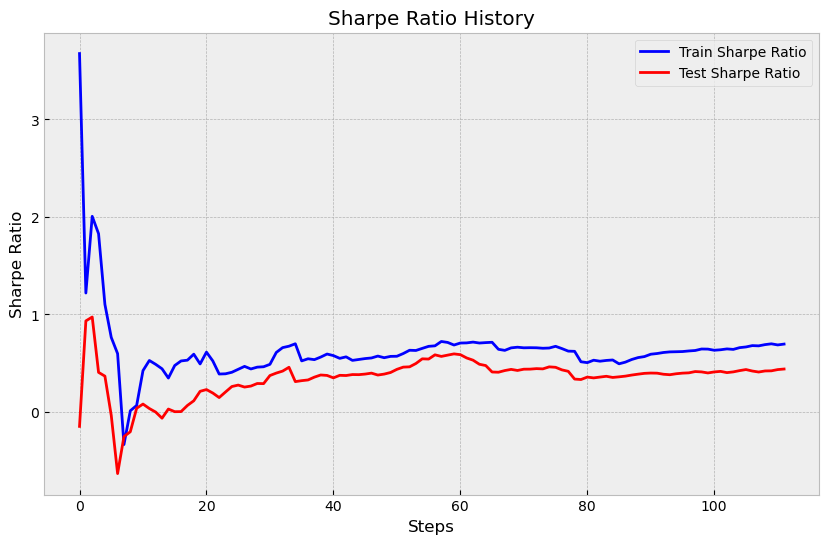

In [275]:
plt.figure(figsize=(10, 6))
plt.plot(history[0], label='Train Sharpe Ratio', color='blue')
plt.plot(history[1], label='Test Sharpe Ratio', color='red')
plt.xlabel('Steps')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio History')
plt.legend()
plt.show()

In [276]:
portfolio_returns = log_returns[1+TIMESTEPS:] * allocations[:-1]


sharpe_ratio(log_returns[1:]).numpy(), sharpe_ratio(portfolio_returns).numpy()

(0.43478016352832805, 0.44033211734821803)

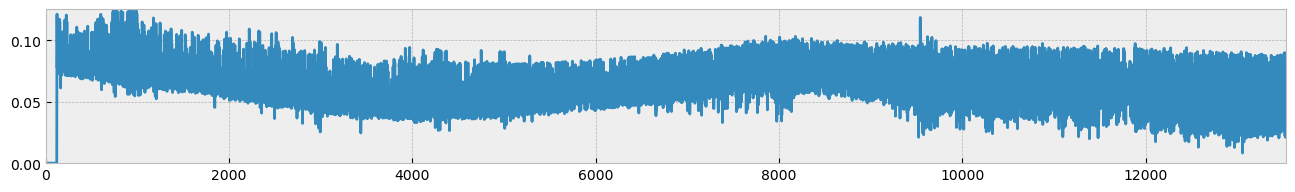

In [277]:
plot(allocations)

(13781,) (13531,)
Benchmark Sharpe Ratio: 0.4434990727120904
Strategy Sharpe Ratio: 0.44033211734821803


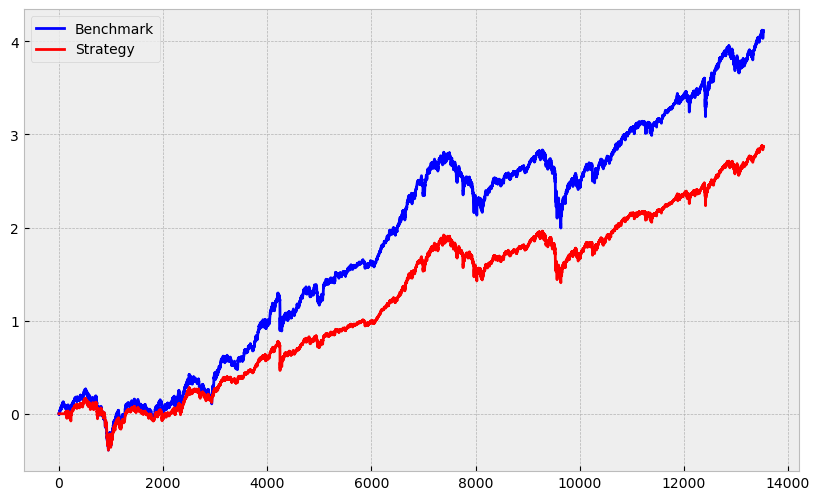

In [278]:
print(log_returns.shape, allocations.shape)

test_idx = int(len(log_returns) * 0.5)
test_idx = 0

a = log_returns[1+TIMESTEPS:]

print(f'Benchmark Sharpe Ratio: {sharpe_ratio(log_returns[1+TIMESTEPS+test_idx:])}')
print(f'Strategy Sharpe Ratio: {sharpe_ratio(portfolio_returns[test_idx:])}')

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(log_returns[1+TIMESTEPS+test_idx:]), label='Benchmark', color='blue')
plt.plot(np.cumsum(portfolio_returns[test_idx:]*10), label='Strategy', color='red')
plt.legend()


In [152]:
train_returns = timeseries[TIMESTEPS-1:][:len(x_train)]
test_returns = timeseries[-len(x_test)-1:-1]

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 250)]             0         
                                                                 
 dense_59 (Dense)            (None, 64)                16064     
                                                                 
 dropout_38 (Dropout)        (None, 64)                0         
                                                                 
 dense_60 (Dense)            (None, 64)                4160      
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_61 (Dense)            (None, 1)                 65        
                                                                 
Total params: 20,289
Trainable params: 20,289
Non-trainabl

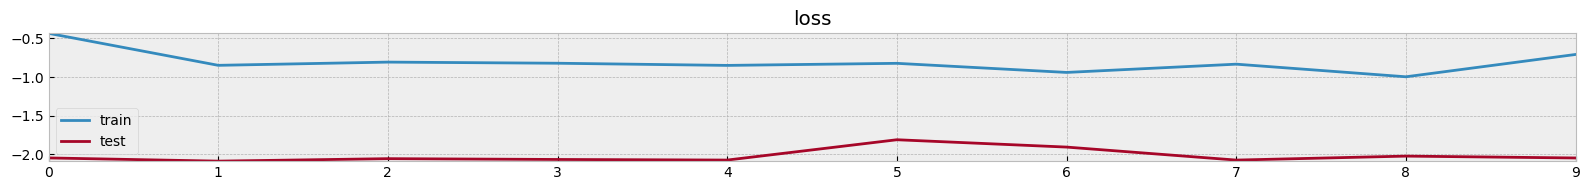

In [153]:
def sharpe_ratio(returns):
    mean_return = tf.reduce_mean(returns)
    std_return = tf.math.reduce_std(returns)
    # if (std_return <= 0): return 0.
    sharpe = mean_return / std_return
    return sharpe * np.sqrt(252.0)

def sharpe_loss(log_returns, allocations):
    portfolio_returns = log_returns[1:, 0] * allocations[:-1, 0]
    # Negative Sharpe ratio (to maximize it)
    return -sharpe_ratio(portfolio_returns)

def build_dense(input_shape):
    input = Input(shape=input_shape)
    x = Dense(64, activation='relu')(input)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation='tanh')(x)
    return Model(input, x)

model = build_dense(x_train.shape[1:])
model.compile(loss=sharpe_loss)
model.summary()

history = model.fit(x_train, train_returns, batch_size=8, epochs=10, validation_data=(x_test, test_returns))
plot_training(history, 'loss')

In [154]:
allocations = model.predict(x_test)[:, 0]
portfolio_returns = test_returns[1:] * allocations[:-1]


sharpe_ratio(test_returns[1:]).numpy(), sharpe_ratio(portfolio_returns).numpy()

127/127 [==============================] - 0s 2ms/step


(0.451801950727601, 0.43543670295032216)

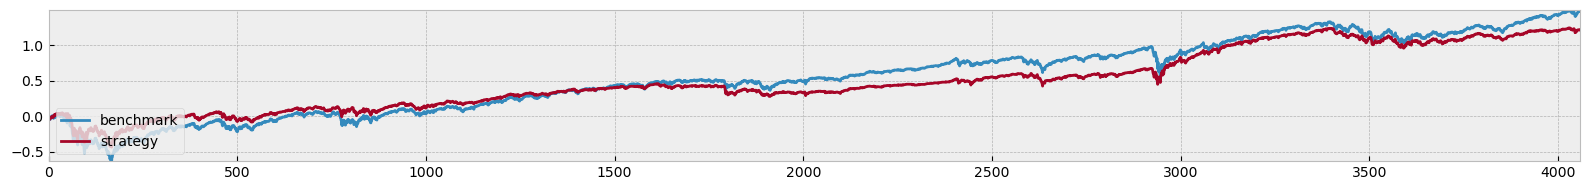

In [155]:
plot_timeseries(index=np.arange(len(x_test)-1), benchmark=np.cumsum(test_returns[1:]), strategy=np.cumsum(portfolio_returns))

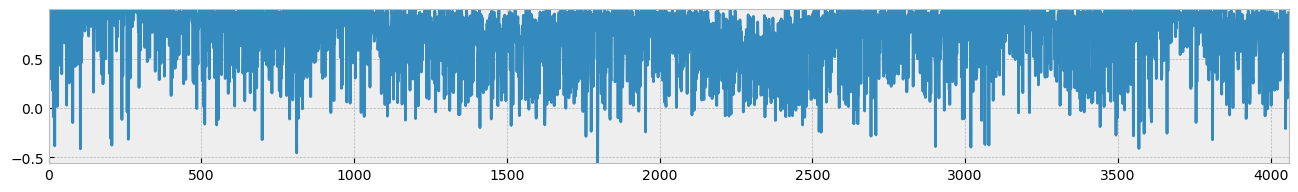

In [156]:
plot(allocations)